In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from itertools import islice

In [2]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from estimator import PerceiverAREstimator

In [3]:
dataset = get_dataset("electricity")

In [14]:
estimator = PerceiverAREstimator(
    depth=2,
    freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*10,
    num_feat_static_cat=1,
    cardinality=[321],
    embedding_dimension=[3],

    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=20, accelerator='cpu'),
)

In [ ]:
predictor = estimator.train(
    training_data=dataset.train,
    num_workers=8,
    shuffle_buffer_length=1024
)

/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1788: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/opt/homebrew/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:117: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type             | Params
-------------------------------------------
0 | model | PerceiverARModel

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 6.39245 (best 6.39245), saving model to '/Users/kashif/Documents/GitHub/pytorch-transformer-ts/perceiverar/lightning_logs/version_16/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 5.74574 (best 5.74574), saving model to '/Users/kashif/Documents/GitHub/pytorch-transformer-ts/perceiverar/lightning_logs/version_16/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 5.66502 (best 5.66502), saving model to '/Users/kashif/Documents/GitHub/pytorch-transformer-ts/perceiverar/lightning_logs/version_16/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' was not in top 1
Epoch 4, global step 500: 'train_loss' was not in top 1
Epoch 5, global step 600: 'train_loss' reached 5.53011 (best 5.53011), saving model to '/Users/kashif/Documents/GitHub/pytorch-transformer-ts/perceiverar/lightning_logs/version_16/checkpoints/epoch=5-step=600.ckpt' a

In [6]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor
)

In [7]:
forecasts = list(forecast_it)

In [8]:
tss = list(ts_it)

In [9]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 2247/2247 [00:00<00:00, 28388.12it/s]
/Users/kashif/Github/gluon-ts/src/gluonts/evaluation/_base.py:361: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/kashif/Github/gluon-ts/src/gluonts/evaluation/_base.py:361: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/opt/homebrew/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [10]:
agg_metrics

{'MSE': 51121382.50806745,
 'abs_error': 45470724.97791672,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 3.3772790741328946,
 'MAPE': 0.5094233835707134,
 'sMAPE': 0.34459815313825437,
 'MSIS': 61.44150428863099,
 'QuantileLoss[0.1]': 51517043.98430869,
 'Coverage[0.1]': 0.4415146120753597,
 'QuantileLoss[0.2]': 53234031.51177651,
 'Coverage[0.2]': 0.4857031597685803,
 'QuantileLoss[0.3]': 52016127.051792935,
 'Coverage[0.3]': 0.5158359293873312,
 'QuantileLoss[0.4]': 49268952.23515242,
 'Coverage[0.4]': 0.5437249666221629,
 'QuantileLoss[0.5]': 45470724.63391817,
 'Coverage[0.5]': 0.5712616822429907,
 'QuantileLoss[0.6]': 40701344.414245784,
 'Coverage[0.6]': 0.6007454383622608,
 'QuantileLoss[0.7]': 34925618.19069028,
 'Coverage[0.7]': 0.6430982050140928,
 'QuantileLoss[0.8]': 27873758.177450046,
 'Coverage[0.8]': 0.7015279632102063,
 'QuantileLoss[0.9]': 18876041.64433915,
 'Coverage[0.9]': 0.7819685506601394,

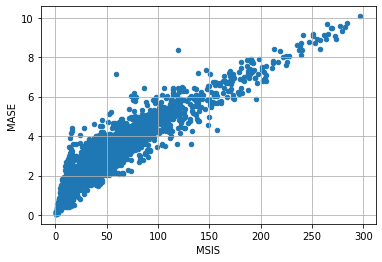

In [11]:
ts_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

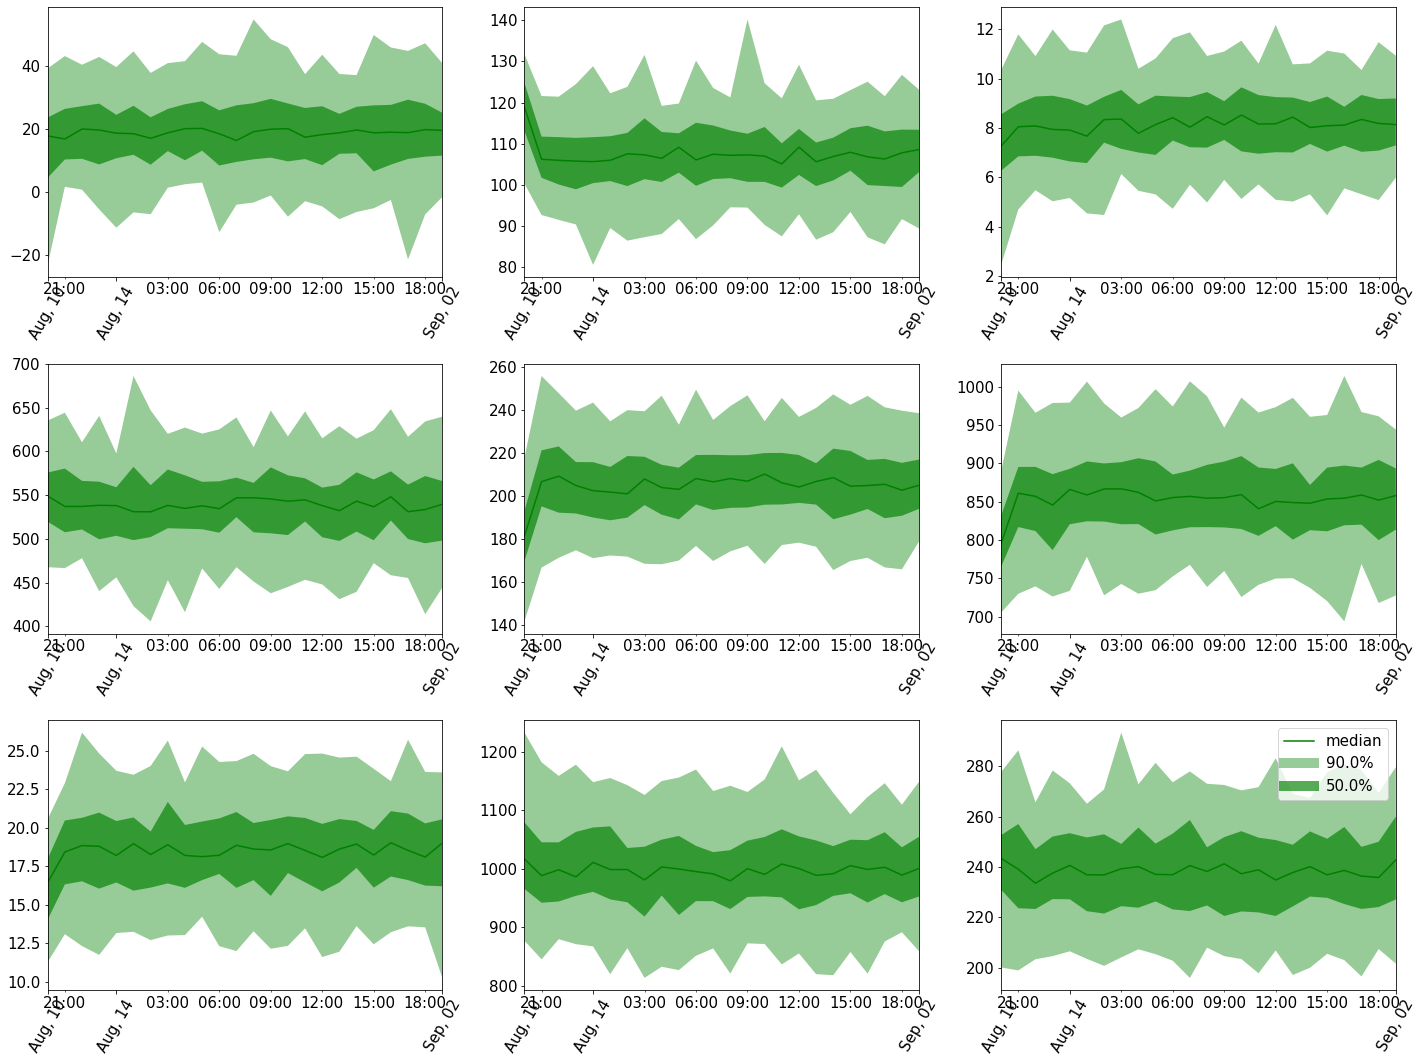

In [13]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:], label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()